# Import Data

In [1]:
#Dataframes
import pandas as pd
import numpy as np
import pprint

#Scikit learn models and performance
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('ConoTrainingData.csv')
test_df = pd.read_csv('ConoTestData.csv')

In [3]:
display(train_df.describe())
display(test_df.describe())

,CLASS LABEL,SEQUENCE,ACC_ID
count,145,145,145
unique,3,145,145
top,Ca,GCCSHPACSVNHPELC,Q1L777
freq,70,1,1


,CLASS LABEL,SEQUENCE,ACC_ID
count,70,70,70
unique,3,67,70
top,Na,GHVPCGKDGRKCGYHADCCNCCLSGICKPSTSWTGCSTSTFD,P0C828
freq,37,2,1


In [4]:
print(f"Train Ca Count: {train_df['CLASS LABEL'].value_counts()['Ca']}")
print(f"Train K  Count: {train_df['CLASS LABEL'].value_counts()['K']}")
print(f"Train Na Count: {train_df['CLASS LABEL'].value_counts()['Na']}")

print(f"Test Ca Count: {test_df['CLASS LABEL'].value_counts()['Ca']}")
print(f"Test K  Count: {test_df['CLASS LABEL'].value_counts()['K']}")
print(f"Test Na Count: {test_df['CLASS LABEL'].value_counts()['Na']}")

Train Ca Count: 70
Train K  Count: 26
Train Na Count: 49
Test Ca Count: 21
Test K  Count: 12
Test Na Count: 37


In [5]:
train_df.head()

,CLASS LABEL,SEQUENCE,ACC_ID
0,Ca,GCCSHPACSVNHPELC,Q1L777
1,Ca,CYDGGTSCDSGIQCCSGWCIFVCL,Q9U648
2,Ca,ATDCIEAGNYCGPTVMKICCGFCSPYSKICMNYPKN,Q5K0D6
3,Ca,CRPSGSPCGVTSICCGRCSRGKCT,Q5K0D5
4,Ca,TCNTPTQYCTLHRHCCSLYCHKTIHACA,Q9XYZ1


In [6]:
test_df.head()

,CLASS LABEL,SEQUENCE,ACC_ID
0,K,QKSLVPSVITTCCGYDPGTMCPPCRCTNSC,P0C828
1,K,SRCFPPGIYCTPYLPCCWGICCGTCRNVCHLRI,Q7YZS9
2,K,CRAEGTYCENDSQCCLNECCWGGCGHPCRHP,Q9U3Z3
3,K,SRCFPPGIYCTPYLPCCWGICCDTCRNVCHLRF,P69501
4,K,CFPPGIYCTPYLPCCWGICCGTCRNVCHLRI,P0C252


# Data Pre-Processing
Peptide sequences are a 1-Dimensional Feature
One-hot encoding to process categorical strings into numerical variables

Steps:
1. Normalize all sequences to the same dimensions (adding 0s to match all sequence lengths)
- There are 20 amino acids + 1 for padding, N sequences in the dataset
2. One-hot encode all sequences for a 21 x N dimension feature set

### Normalizing Sequence Length (Amino Acid Alignment) - Not Used


In [ ]:
#1. Find Maximum Sequence Length
def max_seq_len(df):
    max_seq_length: int = 0
    max_seq: str = ""
    for row in df.values:
        seq = row[1]
        if len(seq) > max_seq_length:
            max_seq_length = len(seq)
            
    return max_seq_length

train_max_seq_len = max_seq_len(train_df)
test_max_seq_len = max_seq_len(test_df)
print(train_max_seq_len, test_max_seq_len)

In [ ]:
#2. add features to df to normalize lengths of all sequences
def normalize_seq_lens(df, max_seq_len):
    col_names = []
    for aa_pos in range(1, max_seq_len + 1):
        col_name = f"amino_acid {aa_pos}"
        col_names.append(col_name)
        col_values = []
        for row in df.values:
            seq = row[1]
            if aa_pos > len(seq):
                col_values.append('0')
            else:
                amino_acid = list(seq)[aa_pos-1]
                col_values.append(amino_acid)

        df[col_name] = col_values
    return df, col_names

#3. adds padding to sequences
def add_padding(df):
    num_instances = len(df.values)
    df["pad"] = ['-'] * num_instances
    return df

train_df, train_col_names = normalize_seq_lens(train_df, train_max_seq_len)
print(train_max_seq_len)
# train_df = add_padding(train_df)

test_df, test_col_names = normalize_seq_lens(test_df, test_max_seq_len)
# test_df = add_padding(test_df)
display(train_df)
display(test_df)

In [ ]:
X_train = transformed_train_df.drop(["CLASS LABEL", "SEQUENCE", "ACC_ID"], axis=1)
y_train = transformed_train_df["CLASS LABEL"]

X_test = transformed_test_df.drop(["CLASS LABEL", "SEQUENCE", "ACC_ID"], axis=1)
y_test = transformed_test_df["CLASS LABEL"]

### Amino Acid Composition Freqs

In [ ]:
#Build Composition freqs
#Composition (frequencies of total amino acids)
def aa_comp_freq(sequence):
    '''
    Builds Amino Acid Composition Frequencies
    For each of the 20 amino acids, determine the frequency of occurrence in sequence
    
    Parameters
    ----------
    sequence: str
        A sequence of amino acids
    
    Returns
    -------
    freq: dict
        Frequencies of amino acid occurence
    '''
    #Initializing keys of freq dict
    amino_acids = np.array(['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V'])
    freq = {}
    for aa in amino_acids:
        freq[aa] = 0
        
    #Add Counts
    for aa in sequence:
        freq[aa] = freq.get(aa, 0) + 1
    
    #Add Frequencies of Counts
    for key, val in freq.items():
        freq[key] = val / len(sequence)
        
    return freq

def add_aa_comp_freq(df):
    '''
    Adds 20 features to the dataframe (for each amino acid)
    Each instance contains frequency of amino acids to the length of the sequence
    
    Parameters
    ----------
    df: DataFrame()
        Pandas DataFrame containing columns of features and rows for instances
    
    Returns
    -------
    df: DataFrame()
        The tranformed DataFrame with additional 20 features
    '''
    #Initializing keys of col_values dict
    amino_acids = np.array(['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V'])
    col_values = {}
    for aa in amino_acids:
        col_name = f"{aa}_freq"
        col_values[col_name] = np.array([])
    
    #Build values for each column
    for idx, row in df.iterrows():
        seq = row["SEQUENCE"]
        freq = aa_comp_freq(seq)
        #Filling col_values with appropriate values
        for key, val in freq.items():
            col_name = f"{key}_freq"
            #Append frequencies of each amino acid
            col_values[col_name] = np.append(col_values[col_name], val)
    
    #Append column_values to dataframe column
    for key, val in col_values.items():
        df[key] = val
    return df

In [ ]:
#Add composition frequencies to train and test df
train_df = add_aa_comp_freq(train_df)
test_df = add_aa_comp_freq(test_df)
display(train_df)
display(test_df)

### Cysteine Framework and Loop Class 

In [ ]:
def cysteine_framework(sequence):
    '''
    Determines the Cysteine Framework of an amino acid sequence
    
    Parameters
    ----------
    sequence: str
        A sequence of amino acids
    
    Returns
    -------
    cys_framework: str
        Cysteine Framework pattern in sequence
    cys_pos: list
        Positions of Cysteines in sequence
        
    Ex:
        Sequence: GCCSDPRCAWRCX
        Cysteine Framework: CC-C-C
        Cysteine Positions: [1, 2, 7, 11]
    '''
    
    #What if there are novel cysteine patterns/no cysteines 
    #-> What cysteine structure label?
    #What is #10?
    
    #Remove 10, combine 6 and 7
    #1, 3, 6, 7 Cys Framework most common?
    cys_framework_dict = {
        "CC-C-C": 1,
        "CCC-C-C-C": 2,
        "CC-C-C-CC": 3,
        "CC-C-C-C-C": 4,
        "CC-CC": 5,
        "C-C-CC-C-C": "6 and 7",
        "C-C-C-C-C-C-C-C-C-C": 8,
        "C-C-C-C-C-C": 9,
        "C-C-CC-CC-C-C": 11,
        "C-C-C-C-CC-C-C": 12,
        "C-C-C-CC-C-C-C": 13,
        "C-C-C-C": 14,
        "C-C-CC-C-C-C-C": 15,
        "C-C-CC": 16,
        "C-C-CC-C-CC-C": 17,
        "C-C-CC-CC": 18,
        "C-C-C-CCC-C-C-C-C": 19,
        "C-CC-C-CC-C-C-C-C": 20,
        "CC-C-C-C-CC-C-C-C": 21,
        "C-C-C-C-C-C-C-C": 22,
        "C-C-C-CC-C": 23,
        "C-CC-C": 24,
        "C-C-C-C-CC": 25,
        "C-C-C-C-CC-CC": 26,
        "C-CC-C-C-C": 27,
        "Novel": "Novel"
    }
    cys_framework = 0
    cys_pattern_str = ""
    cys_pos = []
    
    #Finding Positions of Cysteines in Sequence
    for idx, a_acid in enumerate(sequence):
        if a_acid == 'C':
            cys_pos.append(idx)
    
    #NO CYSTEINES FOUND
    if len(cys_pos) == 0:
        return cys_framework_dict["Novel"], "", cys_pos
    if len(cys_pos) == 1:
        return cys_framework_dict["Novel"], "C", cys_pos
    
    cys_pattern_str += "C"
    #Building Cysteine Framework String
    for idx in range(1, len(cys_pos)):
        #if position of Cysteine is next to a previous Cysteine
        if cys_pos[idx] == (cys_pos[idx - 1] + 1):        
            cys_pattern_str += "C"
        else:
            cys_pattern_str += "-C"
    
    if cys_pattern_str in cys_framework_dict:
        cys_framework = cys_framework_dict[cys_pattern_str]
    else:
        cys_framework = "Novel"
    return cys_framework, cys_pattern_str, cys_pos

def add_cysteine_framework(df):
    '''
    Adds cysteine framework feature to the dataframe
    
    Parameters
    ----------
    df: DataFrame()
        Pandas DataFrame containing columns of features and rows for instances
    
    Returns
    -------
    df: DataFrame()
        The tranformed DataFrame with additional feature
    '''
    #Column value dictionary
    col_values = {
        "Cys. Fmwk - 1": [],
        "Cys. Fmwk - 2": [],
        "Cys. Fmwk - 3": [],
        "Cys. Fmwk - 4": [],
        "Cys. Fmwk - 5": [],
        "Cys. Fmwk - 6 and 7": [],
        "Cys. Fmwk - 8": [],
        "Cys. Fmwk - 9": [],
        "Cys. Fmwk - 11": [],
        "Cys. Fmwk - 12": [],
        "Cys. Fmwk - 13": [],
        "Cys. Fmwk - 14": [],
        "Cys. Fmwk - 15": [],
        "Cys. Fmwk - 16": [],
        "Cys. Fmwk - 17": [],
        "Cys. Fmwk - 18": [],
        "Cys. Fmwk - 19": [],
        "Cys. Fmwk - 20": [],
        "Cys. Fmwk - 21": [],
        "Cys. Fmwk - 22": [],
        "Cys. Fmwk - 23": [],
        "Cys. Fmwk - 24": [],
        "Cys. Fmwk - 25": [],
        "Cys. Fmwk - 26": [],
        "Cys. Fmwk - 27": [],
        "Cys. Fmwk - Novel": []
    }
    
    #Build values for the column
    for idx, row in df.iterrows():
        seq = row["SEQUENCE"]
        cys_framework, cys_pattern_str, cys_pos = cysteine_framework(seq)
        col_name = f"Cys. Fmwk - {cys_framework}"
        # col_values[col_name] = np.append(col_values["Cysteine Framework"], cys_framework)
        
        for key in col_values:
            if key == col_name:
                col_values[key].append(1)
            else:
                col_values[key].append(0)
    
    #Append column_values to dataframe column
    for key, val in col_values.items():
        df[key] = val
    
    return df

In [ ]:
def loop_class(sequence):
    '''
    Determines the Loop Class of an amino acid sequence
    
    Parameters
    ----------
    sequence: str
        A sequence of amino acids
    
    Returns
    -------
    loop_class: str
        The loop class for the sequence
    
    Ex:
        Sequence: GCCSDPRCAWRCX
        Loop Class: [0, 4, 3]
    '''
    loop_class = []
    cys_framework, cys_pattern_str, cys_pos = cysteine_framework(sequence)
    
    #Base Case: NO Loop Class
    if len(cys_pos) < 2:
        return loop_class
    
    #Array of longest contiguous Amino Acid (Sequence, Length) pairs
    contig_aa = []
    
    for idx in range(0, len(cys_pos) - 1):
        #Cysteine Pairs
        l = cys_pos[idx]
        r = cys_pos[idx + 1]
        
        #Contiguous amino acid sequences
        contig_aa_seq = ""
        
        for pos in range(l+1, r):
            #Building Contiguous Amino Acid Seq.
            contig_aa_seq += sequence[pos]
            
        contig_aa.append((contig_aa_seq, len(contig_aa_seq)))
    
    if len(contig_aa) < 1:
        contig_aa.append(("", 0))
        
    loop_class = ' '.join([str(seq_len) for contig_seq, seq_len in contig_aa])
    print(loop_class)
    return loop_class

def add_loop_class(df):
    '''
    Adds loop class feature to the dataframe
    
    Parameters
    ----------
    df: DataFrame()
        Pandas DataFrame containing columns of features and rows for instances
    
    Returns
    -------
    df: DataFrame()
        The tranformed DataFrame with additional feature
    '''
    #Column value dictionary
    col_values = {
        "Loop Class": []
    }
    count = 0
    
    #Build values for the column
    for idx, row in df.iterrows():
        count += 1
        seq = row["SEQUENCE"]
        _loop_class = loop_class(seq)
        col_values["Loop Class"] = np.append(col_values["Loop Class"], _loop_class)

    print(f"{col_values} + {len(col_values['Loop Class'])} + {count}")
    #Append column_values to dataframe column
    for key, val in col_values.items():
        df[key] = val
    
    return df

In [ ]:
seq1 = "GCSHPADDSVNHPELD"
seq2 = "GCCSDPRCAWRCX"
seq3 = "EGCCNGPKGCSSKWCRDHARCCX"

cys_framework, cys_pattern_str, cys_pos = cysteine_framework("CRPSGSPCGVTSICCGRCSRGKCT")
_loop_class = loop_class("DPAACGRIHYKD")

print(f"Cysteine Framework: {cys_framework}, Cysteine Pattern: {cys_pattern_str}")
print(f"Loop Class: {_loop_class}")

# unique_cys_seqs = []
# for row in train_df.values:
#     seq = row[1]
#     cys_framework, cys_pattern_str, cys_pos = cysteine_framework(seq)
#     if cys_framework == "Novel":
#         unique_cys_seqs.append((seq, cys_framework, cys_pattern_str))
        
# print(f"Unique Cysteine Sequences: {unique_cys_seqs}")

In [ ]:
train_df = add_cysteine_framework(train_df)
test_df = add_cysteine_framework(test_df)
display(train_df)
display(test_df)

In [ ]:
print(train_df.iloc[49])
test = add_loop_class(train_df[:49])
# test_df = add_loop_class(test_df)
display(test)
# display(test_df)

In [ ]:
'''
Getting Counts of each Cysteine Framework
'''
train_cys_fmwk_counts = {}
for col_name in train_df.columns:
    if "Cys. Fmwk" in col_name:
        val_counts = train_df[col_name].value_counts()
        if 1 in val_counts:
            train_cys_fmwk_counts[col_name] = val_counts[1]
        # else:
        #     train_cys_fmwk_counts[col_name] = 0

test_cys_fmwk_counts = {}
for col_name in test_df.columns:
    if "Cys. Fmwk" in col_name:
        val_counts = test_df[col_name].value_counts()
        if 1 in val_counts:
            test_cys_fmwk_counts[col_name] = val_counts[1]
        # else:
        #     test_cys_fmwk_counts[col_name] = 0

print("Train Cysteine Framework Counts")
display(train_cys_fmwk_counts)
print("Test Cysteine Framework Counts")
display(test_cys_fmwk_counts)

# print(1 in train_df["Cys. Fmwk - 1"].value_counts())
# print(f"Train Cys. Framework 1 Count:\n{train_df['Cysteine Framework'].value_counts()}")

### K-Mer Frequencies
- Look at frequencies of occurence of all di-amino_acid bonds
- Direction of Di-Amino_Acid bonds matter
- Amino Acids:
    ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
 - Ex:
    ['AA', 'AR', 'AN', 'AD', 'AC', ......
     'RA', 'RR', 'RN', 'RD', 'RC, .......]

In [7]:
def KmerFreqs(_sequence):
    '''
    Determines the K-Mer frequencies of an amino acid sequence
    
    Parameters
    ----------
    _sequence: str
        A sequence of amino acids
    
    Returns
    -------
    k_mers: dict
        The frequencies of all di-amino_acid pairs in sequence
    
    Ex:
        Sequence: GCCSDPRCAWRCX
        k_mers = {'GC': 1, 'CC': 1 / len(seq), 'CS': 1, 'SD': 1, 'DP': 1, 'PR': 1, 'RC': 2, 'CA': 1, 'AW': 1, 'WR': 1, 'CX': 1}
    '''
    amino_acids = np.array(['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V'])
    kmer_freqs = {}
    for aa1 in amino_acids:
        for aa2 in amino_acids:
            #di-amino acid pair
            di_aa_pair = aa1 + aa2
            kmer_freqs[di_aa_pair] = 0
    
    #Getting di amino acid pairs from sequence
    for idx in range(0, len(_sequence) - 1):
        aa_seq1 = _sequence[idx]
        aa_seq2 = _sequence[idx + 1]
#         print(aa_seq1, aa_seq2)
        aa_pair = aa_seq1 + aa_seq2
        kmer_freqs[aa_pair] = kmer_freqs.get(aa_pair, 0) + 1
    
    for key, val in kmer_freqs.items():
        kmer_freqs[key] = val / len(_sequence)
        
    return kmer_freqs

def add_KmerFreqs(df):
    '''
    Adds cysteine framework feature to the dataframe
    
    Parameters
    ----------
    df: DataFrame()
        Pandas DataFrame containing columns of features and rows for instances
    
    Returns
    -------
    df: DataFrame()
        The tranformed DataFrame with additional feature
    '''
    #Initializing keys of col_values dict
    amino_acids = np.array(['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V'])
    kmer_freqs = {}
    for aa1 in amino_acids:
        for aa2 in amino_acids:
            #di-amino acid pair
            di_aa_pair = aa1 + aa2 + "_Kmer_freq"
            kmer_freqs[di_aa_pair] = np.array([])

    #Build values for each column
    for idx, row in df.iterrows():
        seq = row["SEQUENCE"]
        #Get Kmer Frequencies of sequence
        freq = KmerFreqs(seq)
        #Filling col_values with appropriate values
        for key, val in freq.items():
            col_name = f"{key}_Kmer_freq"
            #Append frequencies of each amino acid
            kmer_freqs[col_name] = np.append(kmer_freqs[col_name], val)
    
    #Append column_values to dataframe column
    for key, val in kmer_freqs.items():
        df[key] = val
        
    return df

In [8]:
#Example Kmer Freq on Sequence
seq2 = "GCCSDPRCAWRCX"
print(KmerFreqs(seq2))

{'AA': 0.0, 'AR': 0.0, 'AN': 0.0, 'AD': 0.0, 'AC': 0.0, 'AQ': 0.0, 'AE': 0.0, 'AG': 0.0, 'AH': 0.0, 'AI': 0.0, 'AL': 0.0, 'AK': 0.0, 'AM': 0.0, 'AF': 0.0, 'AP': 0.0, 'AS': 0.0, 'AT': 0.0, 'AW': 0.07692307692307693, 'AY': 0.0, 'AV': 0.0, 'RA': 0.0, 'RR': 0.0, 'RN': 0.0, 'RD': 0.0, 'RC': 0.15384615384615385, 'RQ': 0.0, 'RE': 0.0, 'RG': 0.0, 'RH': 0.0, 'RI': 0.0, 'RL': 0.0, 'RK': 0.0, 'RM': 0.0, 'RF': 0.0, 'RP': 0.0, 'RS': 0.0, 'RT': 0.0, 'RW': 0.0, 'RY': 0.0, 'RV': 0.0, 'NA': 0.0, 'NR': 0.0, 'NN': 0.0, 'ND': 0.0, 'NC': 0.0, 'NQ': 0.0, 'NE': 0.0, 'NG': 0.0, 'NH': 0.0, 'NI': 0.0, 'NL': 0.0, 'NK': 0.0, 'NM': 0.0, 'NF': 0.0, 'NP': 0.0, 'NS': 0.0, 'NT': 0.0, 'NW': 0.0, 'NY': 0.0, 'NV': 0.0, 'DA': 0.0, 'DR': 0.0, 'DN': 0.0, 'DD': 0.0, 'DC': 0.0, 'DQ': 0.0, 'DE': 0.0, 'DG': 0.0, 'DH': 0.0, 'DI': 0.0, 'DL': 0.0, 'DK': 0.0, 'DM': 0.0, 'DF': 0.0, 'DP': 0.07692307692307693, 'DS': 0.0, 'DT': 0.0, 'DW': 0.0, 'DY': 0.0, 'DV': 0.0, 'CA': 0.07692307692307693, 'CR': 0.0, 'CN': 0.0, 'CD': 0.0, 'CC': 0.076

In [9]:
#Add composition frequencies to train and test df
kmer_transf_train_df = add_KmerFreqs(train_df)
kmer_transf_test_df = add_KmerFreqs(test_df)
display(kmer_transf_train_df)
display(kmer_transf_test_df)

train_df = kmer_transf_train_df
test_df = kmer_transf_test_df

,CLASS LABEL,SEQUENCE,ACC_ID,AA_Kmer_freq,AR_Kmer_freq,AN_Kmer_freq,AD_Kmer_freq,AC_Kmer_freq,AQ_Kmer_freq,AE_Kmer_freq,...,VL_Kmer_freq,VK_Kmer_freq,VM_Kmer_freq,VF_Kmer_freq,VP_Kmer_freq,VS_Kmer_freq,VT_Kmer_freq,VW_Kmer_freq,VY_Kmer_freq,VV_Kmer_freq
0,Ca,GCCSHPACSVNHPELC,Q1L777,0.0,0.0,0.0,0.000000,0.062500,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
1,Ca,CYDGGTSCDSGIQCCSGWCIFVCL,Q9U648,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
2,Ca,ATDCIEAGNYCGPTVMKICCGFCSPYSKICMNYPKN,Q5K0D6,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.027778,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
3,Ca,CRPSGSPCGVTSICCGRCSRGKCT,Q5K0D5,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.041667,0.0,0.000000,0.0
4,Ca,TCNTPTQYCTLHRHCCSLYCHKTIHACA,Q9XYZ1,0.0,0.0,0.0,0.000000,0.035714,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,Na,HGCCKGPEGCSSRECRPQHCC,P0DKQ9,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
141,Na,WCKQSGEMCNVLDQNCCDGYCIVFVCT,P24159,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.037037,0.0,0.000000,0.037037,0.0,0.0,0.000000,0.0,0.000000,0.0
142,Na,DCIPGGENCDVFRPYRCCSGYCILLLCA,P0CH13,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.035714,0.0,0.0,0.000000,0.0,0.000000,0.0
143,Na,WCKQSGEMCNLLDQNCCDGYCIVFVCT,Q9U656,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.037037,0.0,0.0,0.000000,0.0,0.000000,0.0


,CLASS LABEL,SEQUENCE,ACC_ID,AA_Kmer_freq,AR_Kmer_freq,AN_Kmer_freq,AD_Kmer_freq,AC_Kmer_freq,AQ_Kmer_freq,AE_Kmer_freq,...,VL_Kmer_freq,VK_Kmer_freq,VM_Kmer_freq,VF_Kmer_freq,VP_Kmer_freq,VS_Kmer_freq,VT_Kmer_freq,VW_Kmer_freq,VY_Kmer_freq,VV_Kmer_freq
0,K,QKSLVPSVITTCCGYDPGTMCPPCRCTNSC,P0C828,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0
1,K,SRCFPPGIYCTPYLPCCWGICCGTCRNVCHLRI,Q7YZS9,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,K,CRAEGTYCENDSQCCLNECCWGGCGHPCRHP,Q9U3Z3,0.0,0.0,0.0,0.0,0.000000,0.0,0.032258,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,K,SRCFPPGIYCTPYLPCCWGICCDTCRNVCHLRF,P69501,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,K,CFPPGIYCTPYLPCCWGICCGTCRNVCHLRI,P0C252,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,Ca,CLSPGSSCSPTSYNCCRSCNPYSRKC,P58915,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
66,Ca,DCVAGGHFCGFPKIGGPCCSGWCFFVCA,Q9BPA5,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
67,Ca,DCQEKWDFCPAPFFGSRYCCFGLFCTLFFCA,Q9U644,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
68,Ca,DDCEPPGNFCGMIKIGPPCCSGWCFFACA,Q9U645,0.0,0.0,0.0,0.0,0.034483,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


# Train-Test Split Data

In [10]:
X_train = train_df.drop(["CLASS LABEL", "SEQUENCE", "ACC_ID"], axis=1)
y_train = train_df["CLASS LABEL"]

X_test = test_df.drop(["CLASS LABEL", "SEQUENCE", "ACC_ID"], axis=1)
y_test = test_df["CLASS LABEL"]

# Class Balancing

In [11]:
'''
ADASYN Class Balancing
https://medium.com/coinmonks/smote-and-adasyn-handling-imbalanced-data-set-34f5223e167
'''
from imblearn.over_sampling import ADASYN 
oversampler = ADASYN(random_state = 42)
X_train, y_train = oversampler.fit_resample(X_train, y_train)
X_test, y_test = oversampler.fit_resample(X_test, y_test)

In [12]:
'''
https://github.com/IQTLabs/freqgen
'''

print(f"Train Ca Count: {y_train.value_counts()['Ca']}")
print(f"Train K  Count: {y_train.value_counts()['K']}")
print(f"Train Na Count: {y_train.value_counts()['Na']}")

print(f"Test Ca Count: {y_test.value_counts()['Ca']}")
print(f"Test K  Count: {y_test.value_counts()['K']}")
print(f"Test Na Count: {y_test.value_counts()['Na']}")

Train Ca Count: 70
Train K  Count: 73
Train Na Count: 72
Test Ca Count: 37
Test K  Count: 40
Test Na Count: 37


In [13]:
display(X_train)
display(X_test)

,AA_Kmer_freq,AR_Kmer_freq,AN_Kmer_freq,AD_Kmer_freq,AC_Kmer_freq,AQ_Kmer_freq,AE_Kmer_freq,AG_Kmer_freq,AH_Kmer_freq,AI_Kmer_freq,...,VL_Kmer_freq,VK_Kmer_freq,VM_Kmer_freq,VF_Kmer_freq,VP_Kmer_freq,VS_Kmer_freq,VT_Kmer_freq,VW_Kmer_freq,VY_Kmer_freq,VV_Kmer_freq
0,0.0,0.0,0.0,0.00000,0.062500,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.027778,0.0,0.000000,...,0.000000,0.0,0.027778,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.041667,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.00000,0.035714,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.009938,...,0.000000,0.0,0.022000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
211,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.032961,0.0,0.000000,0.037037,0.0,0.0,0.000000,0.0,0.000000,0.0
212,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.008442,0.0,0.000000,0.036016,0.0,0.0,0.000000,0.0,0.000000,0.0
213,0.0,0.0,0.0,0.00000,0.011240,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.021218,0.0,0.0,0.000000,0.0,0.000000,0.0


,AA_Kmer_freq,AR_Kmer_freq,AN_Kmer_freq,AD_Kmer_freq,AC_Kmer_freq,AQ_Kmer_freq,AE_Kmer_freq,AG_Kmer_freq,AH_Kmer_freq,AI_Kmer_freq,...,VL_Kmer_freq,VK_Kmer_freq,VM_Kmer_freq,VF_Kmer_freq,VP_Kmer_freq,VS_Kmer_freq,VT_Kmer_freq,VW_Kmer_freq,VY_Kmer_freq,VV_Kmer_freq
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.032258,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.027726,0.0,0.0,0.0,0.0,0.0
110,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.024300,0.0,0.0,0.0,0.0,0.0
111,0.0,0.0,0.0,0.0,0.0,0.0,0.024880,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
112,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.002178,0.0,0.0,0.0,0.0,0.0


# Model Training

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

## Random Forest Model

### GridSearch Cross Validation

In [ ]:
'''
converting labels [Ca, Na, K] to [0, 1, 2]
'''
num_y_train = []
num_y_test = []
for label in y_train:
    if label == 'Ca':
        num_y_train.append(0)
    elif label == 'Na':
        num_y_train.append(1)
    elif label == 'K':
        num_y_train.append(2)

for label in y_test:
    if label == 'Ca':
        num_y_test.append(0)
    elif label == 'Na':
        num_y_test.append(1)
    elif label == 'K':
        num_y_test.append(2)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score

# Defining hyper-parameter values
depth = np.linspace(0, 50, num=20).astype(int)
trees = [0, 5, 10, 50, 100, 250, 300, 350, 500, 750, 900, 1000]

# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = RandomForestClassifier(class_weight="balanced", random_state = 42)
# Dictionary of parameters to be searched on 
parameters = {'max_depth':depth,'n_estimators':trees}

# Value on which model will be evaluated. roc_auc_score is used as metric.
# auc_score = make_scorer(roc_auc_score(multi_class='ovr'))

# Calling GridSearchCV with 5-fold cross-validation
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=5,refit=True,scoring="accuracy",n_jobs=-1, verbose=3)

# Training the gridsearchcv instance
grid_model.fit(X_train,num_y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_

In [ ]:
print(grid_model.best_score_)
print(grid_model.best_params_)
print(grid_model.best_estimator_)

In [ ]:
print(optimized_clf)

In [ ]:
y_test_preds_gridsearch = optimized_clf.predict(X_test).tolist()

### Finding Optimal Number of Trees

In [ ]:
from sklearn.model_selection import cross_val_score
def cross_validation_num_trees(X, y, trees_arr, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for trees in trees_arr:
        tree_model = RandomForestClassifier(n_estimators=trees, class_weight="balanced", random_state=42)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores

def plot_cross_validation_on_num_trees(trees_arr, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(trees_arr, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(trees_arr, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(trees_arr, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('# of Trees', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(trees_arr)
    ax.legend()

In [ ]:
sm_num_trees = [5, 10, 50, 100, 250, 300, 350, 500, 750, 900, 1000]
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = cross_validation_num_trees(X_train, y_train, sm_num_trees)

# plotting accuracy
plot_cross_validation_on_num_trees(sm_num_trees, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per Random Forest # of Trees on training data')

idx_max = sm_cv_scores_mean.argmax()
sm_best_num_trees = sm_num_trees[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The {}-of-Trees Random Forest Model achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(
      sm_best_num_trees, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))

### Finding Optimal Tree Depth

In [ ]:
def cross_validation_tree_depth(X, y, tree_depths, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = RandomForestClassifier(max_depth=depth, class_weight="balanced", random_state=42)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores

def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

In [ ]:
# fitting trees of depth 1 to 24
sm_tree_depths = np.linspace(1, 50, num=20).astype(int)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = cross_validation_tree_depth(X_train, y_train, sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')

idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(
      sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))

### Train Model

In [ ]:
#Run cross-validation for optimal number of trees
model = RandomForestClassifier(class_weight='balanced', max_depth=sm_best_tree_depth, n_estimators=sm_best_num_trees, random_state=42)
print(model)
model.fit(X_train, y_train)
y_test_preds = model.predict(X_test)

## Gradient Boosted Models
- GradientBoostingClassifier
- LightGBM
- XGBoost

### Gradient Boosting Classifier

#### GridSearch Cross Validation

In [ ]:
#converting labels [Ca, Na, K] to [0, 1, 2]
num_y_train = []
num_y_test = []
for label in y_train:
    if label == 'Ca':
        num_y_train.append(0)
    elif label == 'Na':
        num_y_train.append(1)
    elif label == 'K':
        num_y_train.append(2)

for label in y_test:
    if label == 'Ca':
        num_y_test.append(0)
    elif label == 'Na':
        num_y_test.append(1)
    elif label == 'K':
        num_y_test.append(2)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier

# Defining hyper-parameter values
depth = np.linspace(0, 50, num=20).astype(int)
trees = [0, 5, 10, 50, 100, 250, 300, 350, 500, 750, 900, 1000]

# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = GradientBoostingClassifier(random_state = 42)
# Dictionary of parameters to be searched on 
parameters = {'max_depth':depth,'n_estimators':trees}

# Value on which model will be evaluated. roc_auc_score is used as metric.
# auc_score = make_scorer(roc_auc_score(multi_class='ovr'))

# Calling GridSearchCV with 5-fold cross-validation
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=5,refit=True,scoring="accuracy",n_jobs=-1, verbose=3)

# Training the gridsearchcv instance
grid_model.fit(X_train,num_y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_

In [ ]:
print(grid_model.best_score_)
print(grid_model.best_params_)
print(grid_model.best_estimator_)

In [ ]:
print(optimized_clf)

In [ ]:
y_test_preds_gridsearch = optimized_clf.predict(X_test).tolist()

#### Finding Optimal Number of Trees

In [ ]:
from sklearn.model_selection import cross_val_score
def cross_validation_num_trees(X, y, trees_arr, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for trees in trees_arr:
        tree_model = GradientBoostingClassifier(n_estimators=trees, random_state=42)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores

def plot_cross_validation_on_num_trees(trees_arr, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(trees_arr, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(trees_arr, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(trees_arr, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('# of Trees', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(trees_arr)
    ax.legend()

In [ ]:
sm_num_trees = [5, 10, 50, 100, 250, 300, 350, 500, 750, 900, 1000]
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = cross_validation_num_trees(X_train, y_train, sm_num_trees)

# plotting accuracy
plot_cross_validation_on_num_trees(sm_num_trees, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per Gradient Boosting # of Trees on training data')

idx_max = sm_cv_scores_mean.argmax()
sm_best_num_trees = sm_num_trees[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The {}-of-Trees Gradient Boosting Classifier Model achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(
      sm_best_num_trees, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))

#### Finding Optimal Tree Depth

In [ ]:
def cross_validation_tree_depth(X, y, tree_depths, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = GradientBoostingClassifier(max_depth=depth, random_state=42)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores

def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

In [ ]:
# fitting trees of depth 1 to 24
sm_tree_depths = np.linspace(1, 50, num=20).astype(int)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = cross_validation_tree_depth(X_train, y_train, sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')

idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(
      sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))

#### Train Model

In [ ]:
#Run cross-validation for optimal number of trees
model = GradientBoostingClassifier(max_depth=sm_best_tree_depth, n_estimators=sm_best_num_trees, random_state=42)
print(model)
model.fit(X_train, y_train)
y_test_preds = model.predict(X_test)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

#Evaluate the model
model = GradientBoostingClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

# fit the model on the whole dataset
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
y_test_preds = model.predict(X_test)

### XGBoost

#### GridSearch Cross Validation

In [14]:
#converting labels [Ca, Na, K] to [0, 1, 2]
num_y_train = []
num_y_test = []
for label in y_train:
    if label == 'Ca':
        num_y_train.append(0)
    elif label == 'Na':
        num_y_train.append(1)
    elif label == 'K':
        num_y_train.append(2)

for label in y_test:
    if label == 'Ca':
        num_y_test.append(0)
    elif label == 'Na':
        num_y_test.append(1)
    elif label == 'K':
        num_y_test.append(2)

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

# Defining hyper-parameter values
depth = np.linspace(0, 50, num=20).astype(int)
trees = [0, 5, 10, 50, 100, 250, 300, 350, 500, 750, 900, 1000]

# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = XGBClassifier(random_state = 42)
# Dictionary of parameters to be searched on 
parameters = {'max_depth':depth,'n_estimators':trees}

# Value on which model will be evaluated. roc_auc_score is used as metric.
# auc_score = make_scorer(roc_auc_score(multi_class='ovr'))

# Calling GridSearchCV with 5-fold cross-validation
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=5,refit=True,scoring="accuracy",n_jobs=-1, verbose=3)

# Training the gridsearchcv instance
grid_model.fit(X_train,num_y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


In [16]:
print(grid_model.best_score_)
print(grid_model.best_params_)
print(grid_model.best_estimator_)

0.8372093023255814
{'max_depth': 2, 'n_estimators': 50}
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)


In [17]:
print(optimized_clf)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)


In [18]:
y_test_preds_gridsearch = optimized_clf.predict(X_test).tolist()

#### Finding Optimal Number of Trees

In [23]:
from sklearn.model_selection import cross_val_score
def cross_validation_num_trees(X, y, trees_arr, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for trees in trees_arr:
        tree_model = XGBClassifier(n_estimators=trees, random_state=42)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores

def plot_cross_validation_on_num_trees(trees_arr, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(trees_arr, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(trees_arr, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(trees_arr, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('# of Trees', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(trees_arr)
    ax.legend()

The 50-of-Trees XGBoost Classifier Model achieves the best mean cross-validation accuracy 83.72093 +/- 8.32025% on training dataset
[CV 2/5] END .........max_depth=0, n_estimators=5;, score=nan total time=   0.0s
[CV 3/5] END .......max_depth=0, n_estimators=100;, score=nan total time=   0.0s
[CV 1/5] END .......max_depth=0, n_estimators=250;, score=nan total time=   0.0s
[CV 3/5] END .....max_depth=2, n_estimators=100;, score=0.837 total time=   0.3s
[CV 4/5] END .....max_depth=2, n_estimators=100;, score=0.860 total time=   0.3s
[CV 1/5] END .....max_depth=2, n_estimators=900;, score=0.744 total time=   2.6s
[CV 2/5] END .....max_depth=2, n_estimators=900;, score=0.698 total time=   2.5s
[CV 3/5] END .....max_depth=2, n_estimators=900;, score=0.791 total time=   2.6s
[CV 4/5] END .....max_depth=2, n_estimators=900;, score=0.791 total time=   2.6s
[CV 1/5] END .....max_depth=7, n_estimators=300;, score=0.837 total time=   1.1s
[CV 5/5] END .....max_depth=7, n_estimators=300;, score=0.

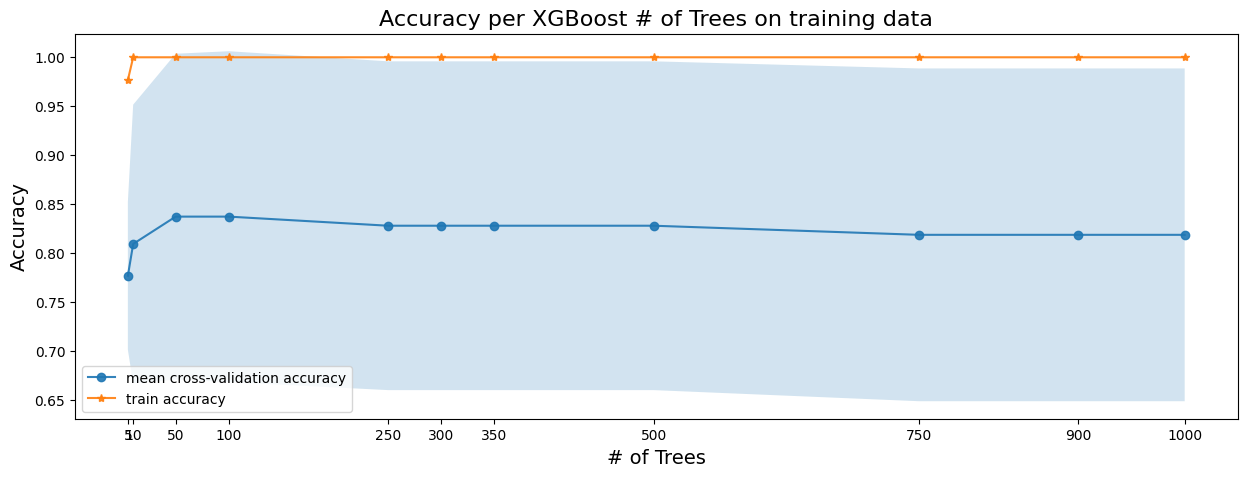

In [24]:
sm_num_trees = [5, 10, 50, 100, 250, 300, 350, 500, 750, 900, 1000]
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = cross_validation_num_trees(X_train, num_y_train, sm_num_trees)

# plotting accuracy
plot_cross_validation_on_num_trees(sm_num_trees, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per XGBoost # of Trees on training data')

idx_max = sm_cv_scores_mean.argmax()
sm_best_num_trees = sm_num_trees[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The {}-of-Trees XGBoost Classifier Model achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(
      sm_best_num_trees, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))

#### Finding Optimal Tree Depth

In [25]:
def cross_validation_tree_depth(X, y, tree_depths, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = XGBClassifier(max_depth=depth, random_state=42)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores

def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

, n_estimators=5;, score=0.791 total time=   0.1s
[CV 4/5] END ......max_depth=28, n_estimators=5;, score=0.744 total time=   0.1s
[CV 1/5] END .....max_depth=28, n_estimators=10;, score=0.791 total time=   0.1s
[CV 3/5] END .....max_depth=28, n_estimators=10;, score=0.814 total time=   0.1s
[CV 5/5] END .....max_depth=28, n_estimators=10;, score=0.930 total time=   0.1s
[CV 2/5] END .....max_depth=28, n_estimators=50;, score=0.744 total time=   0.3s
[CV 5/5] END .....max_depth=28, n_estimators=50;, score=0.977 total time=   0.3s
[CV 4/5] END ....max_depth=28, n_estimators=100;, score=0.744 total time=   0.5s
[CV 5/5] END ....max_depth=28, n_estimators=250;, score=0.977 total time=   1.0s
[CV 4/5] END ....max_depth=28, n_estimators=350;, score=0.744 total time=   1.3s
[CV 4/5] END ....max_depth=28, n_estimators=750;, score=0.744 total time=   2.5s
[CV 4/5] END ...max_depth=28, n_estimators=1000;, score=0.744 total time=   3.3s
[CV 4/5] END ....max_depth=31, n_estimators=300;, score=0.7

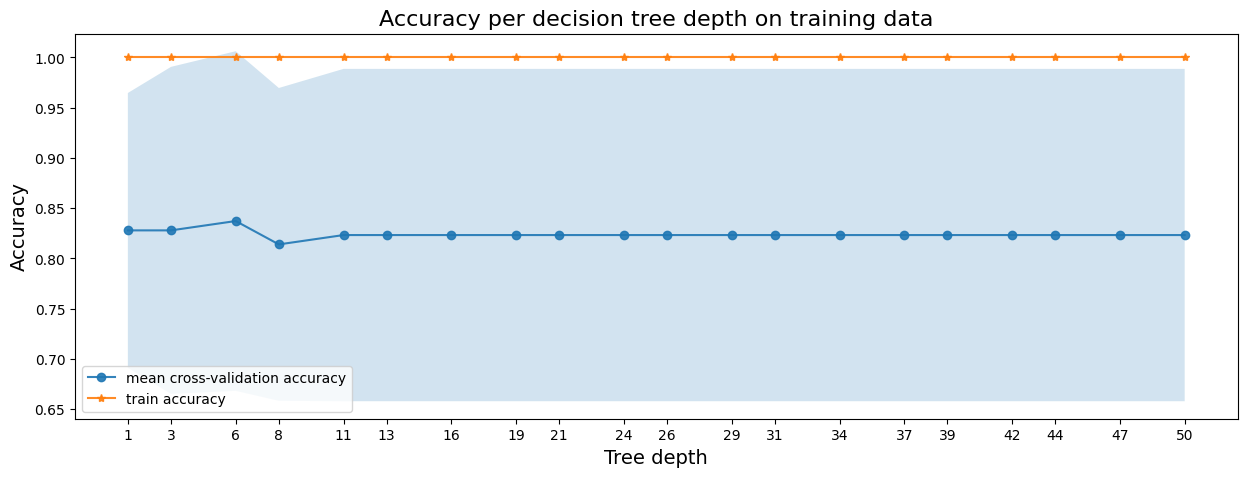

In [26]:
# fitting trees of depth 1 to 24
sm_tree_depths = np.linspace(1, 50, num=20).astype(int)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = cross_validation_tree_depth(X_train, num_y_train, sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')

idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(
      sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))

#### Train Model

In [28]:
#Run cross-validation for optimal number of trees
model = XGBClassifier(max_depth=sm_best_tree_depth, n_estimators=sm_best_num_trees, random_state=42)
print(model)
model.fit(X_train, num_y_train)
y_test_preds = model.predict(X_test)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# evaluate the model
model = XGBClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
n_scores = cross_val_score(model, X_train, num_y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

# fit the model on the whole dataset
model = XGBClassifier()
model.fit(X_train, num_y_train)
y_test_preds = model.predict(X_test)

### LGBM

#### GridSearch Cross Validation

In [ ]:
#converting labels [Ca, Na, K] to [0, 1, 2]
num_y_train = []
num_y_test = []
for label in y_train:
    if label == 'Ca':
        num_y_train.append(0)
    elif label == 'Na':
        num_y_train.append(1)
    elif label == 'K':
        num_y_train.append(2)

for label in y_test:
    if label == 'Ca':
        num_y_test.append(0)
    elif label == 'Na':
        num_y_test.append(1)
    elif label == 'K':
        num_y_test.append(2)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier

# Defining hyper-parameter values
depth = np.linspace(0, 50, num=20).astype(int)
trees = [0, 5, 10, 50, 100, 250, 300, 350, 500, 750, 900, 1000]

# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = LGBMClassifier(random_state = 42)
# Dictionary of parameters to be searched on 
parameters = {'max_depth':depth,'n_estimators':trees}

# Value on which model will be evaluated. roc_auc_score is used as metric.
# auc_score = make_scorer(roc_auc_score(multi_class='ovr'))

# Calling GridSearchCV with 5-fold cross-validation
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=5,refit=True,scoring="accuracy",n_jobs=-1, verbose=3)

# Training the gridsearchcv instance
grid_model.fit(X_train,num_y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_

In [ ]:
print(grid_model.best_score_)
print(grid_model.best_params_)
print(grid_model.best_estimator_)

In [ ]:
print(optimized_clf)

In [ ]:
y_test_preds_gridsearch = optimized_clf.predict(X_test).tolist()

#### Finding Optimal Number of Trees

In [ ]:
from sklearn.model_selection import cross_val_score
def cross_validation_num_trees(X, y, trees_arr, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for trees in trees_arr:
        tree_model = LGBMClassifier(n_estimators=trees, random_state=42)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores

def plot_cross_validation_on_num_trees(trees_arr, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(trees_arr, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(trees_arr, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(trees_arr, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('# of Trees', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(trees_arr)
    ax.legend()

In [ ]:
sm_num_trees = [5, 10, 50, 100, 250, 300, 350, 500, 750, 900, 1000]
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = cross_validation_num_trees(X_train, y_train, sm_num_trees)

# plotting accuracy
plot_cross_validation_on_num_trees(sm_num_trees, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per LightGBM # of Trees on training data')

idx_max = sm_cv_scores_mean.argmax()
sm_best_num_trees = sm_num_trees[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The {}-of-Trees LightGBM Classifier Model achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(
      sm_best_num_trees, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))

#### Finding Optimal Tree Depth

In [ ]:
def cross_validation_tree_depth(X, y, tree_depths, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = LGBMClassifier(max_depth=depth, random_state=42)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores

def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

In [ ]:
# fitting trees of depth 1 to 24
sm_tree_depths = np.linspace(1, 50, num=20).astype(int)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = cross_validation_tree_depth(X_train, y_train, sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')

idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(
      sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))

#### Train Model

In [ ]:
#Run cross-validation for optimal number of trees
model = LGBMClassifier(max_depth=sm_best_tree_depth, n_estimators=sm_best_num_trees, random_state=42)
print(model)
model.fit(X_train, y_train)
y_test_preds = model.predict(X_test)

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# evaluate the model
model = LGBMClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
n_scores = cross_val_score(model, X_train, num_y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

# fit the model on the whole dataset
model = LGBMClassifier()
model.fit(X_train, num_y_train)
y_test_preds = model.predict(X_test)

# Model Evalutation

In [29]:
#Counts of Predictions
print(type(y_test_preds))
print(type(y_test_preds_gridsearch))
print(type(num_y_test))
unique, counts = np.unique(y_test_preds, return_counts=True)
print(np.asarray((unique, counts)).T)

<class 'numpy.ndarray'>
<class 'list'>
<class 'list'>
[[ 0 40]
 [ 1 33]
 [ 2 41]]


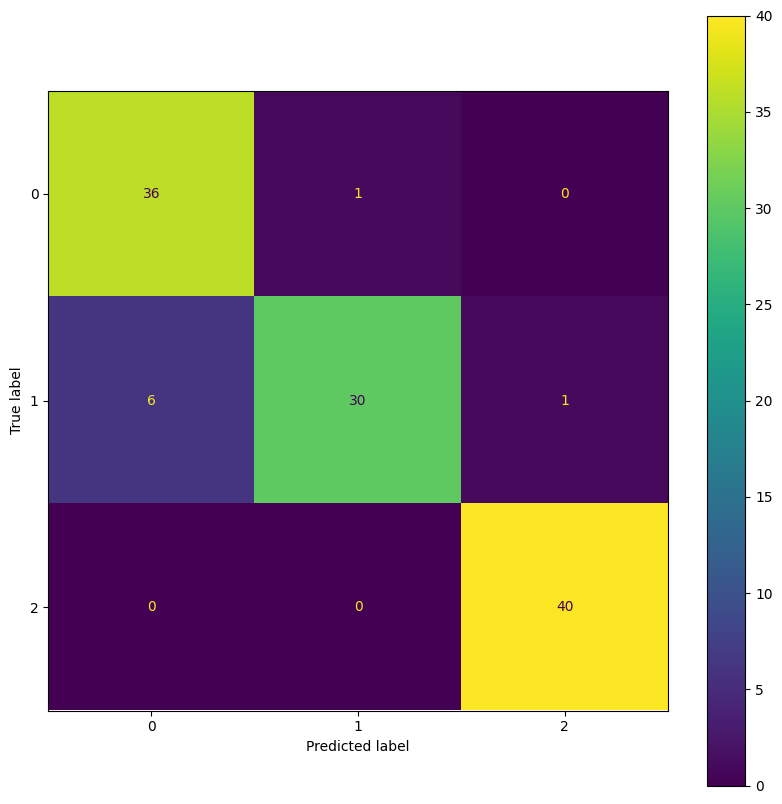

In [30]:
#Plot Configurations
fig, _ = plt.subplots(nrows=1, figsize=(10,10))
ax = plt.subplot(1, 1, 1)
ax.grid(False)

#Confusion Matrix
cm = confusion_matrix(num_y_test, y_test_preds_gridsearch)
# cm = confusion_matrix(y_test, y_test_preds, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(ax=ax)
plt.show()

In [32]:
# Multi-Class Classification Report
print(classification_report(num_y_test, y_test_preds_gridsearch, digits=4))
print(classification_report(num_y_test, y_test_preds, digits=4))

              precision    recall  f1-score   support

           0     0.8571    0.9730    0.9114        37
           1     0.9677    0.8108    0.8824        37
           2     0.9756    1.0000    0.9877        40

    accuracy                         0.9298       114
   macro avg     0.9335    0.9279    0.9271       114
weighted avg     0.9346    0.9298    0.9287       114

              precision    recall  f1-score   support

           0     0.9250    1.0000    0.9610        37
           1     1.0000    0.8919    0.9429        37
           2     0.9756    1.0000    0.9877        40

    accuracy                         0.9649       114
   macro avg     0.9669    0.9640    0.9639       114
weighted avg     0.9671    0.9649    0.9645       114



In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
class_of_interest = "Ca"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
y_score = model.fit(X_train, y_train).predict_proba(X_test)
other_classes = [class_name for class_name in label_binarizer.classes_ if class_name != class_of_interest]

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"One-vs-Rest ROC curves:\n{class_of_interest} vs {','.join(other_classes)}")
plt.legend()
plt.show()

In [ ]:
'''
By the nature of an RF model,  ... . Looks like the best representative feature set
is the Kmer Freqs as when it is combined with other features, theyre essentially ignored. But when combining amino acid freqs and cys. framework,
their resulting performance is better than the feature sets trained on a random forest individually. so we know more features can have an effect on the
resulting performance. guess is that kmer freq features are just more representative. 

'''